# Resolução - Projeto da Renner

# Bibliotecas

### Instalando e importando as bibliotecas necessárias

**geopy**: para o cálculo de distância entre coordenadas.

**pandas**: para criação e manipulação de dataframes.

**pulp**: para modelar e resolver problemas de programação linear.

**numpy**: para utilizar em conjunto com os dataframes do Pandas.

**matplotlib**: para plot de figuras.

**datetime**: para manipulação de datas.

In [66]:
!pip install geopy
!pip install pulp

import pandas as pd
from pulp import *
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import geopy.distance
import datetime

You should consider upgrading via the 'C:\Users\samir\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\samir\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


### Importando os dados da planilha de excel cedida pela Renner

In [67]:
df_CD = pd.read_excel("Dados/case_otimizacao_lojas_renner.xlsx", "Centro de Distribuição")
df_turnos = pd.read_excel("Dados/case_otimizacao_lojas_renner.xlsx", "Turnos")
df_lojas = pd.read_excel("Dados/case_otimizacao_lojas_renner.xlsx", 'Lojas')
df_demanda = pd.read_excel("Dados/case_otimizacao_lojas_renner.xlsx", 'Demanda')
df_veiculos = pd.read_excel("Dados/case_otimizacao_lojas_renner.xlsx", 'Veiculos')

## Apresentação do Case

### Objetivo e contexto do Problema

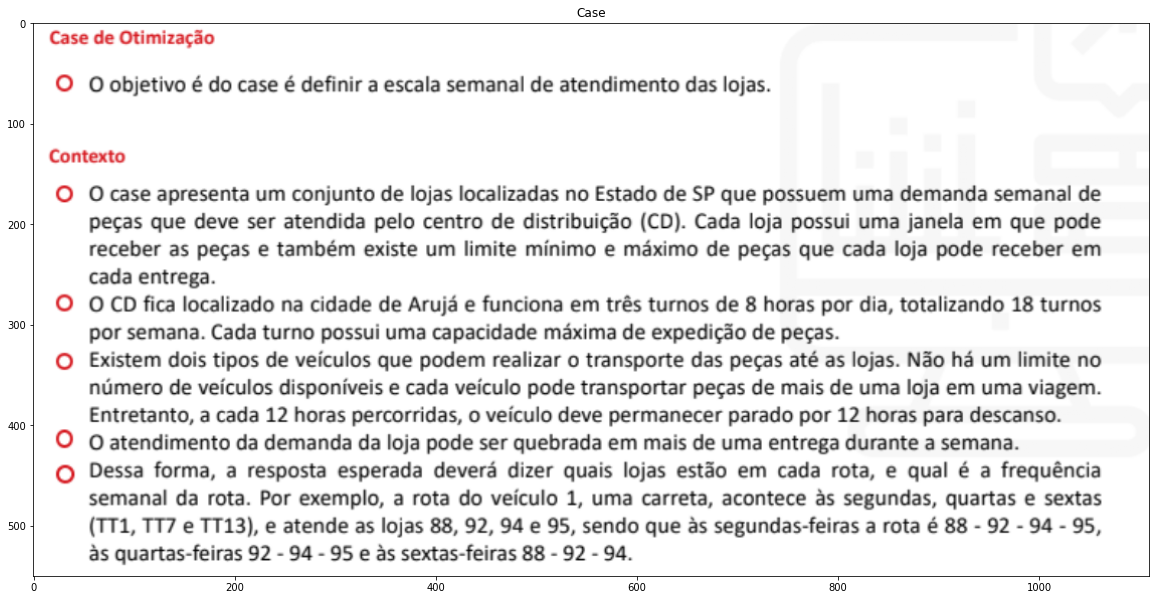

In [68]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.title("Case")
plt.xlabel("")
plt.ylabel("")
 
image = mpimg.imread("Imagens/case.PNG")
plt.imshow(image)
plt.show()

### Restrições do Problema


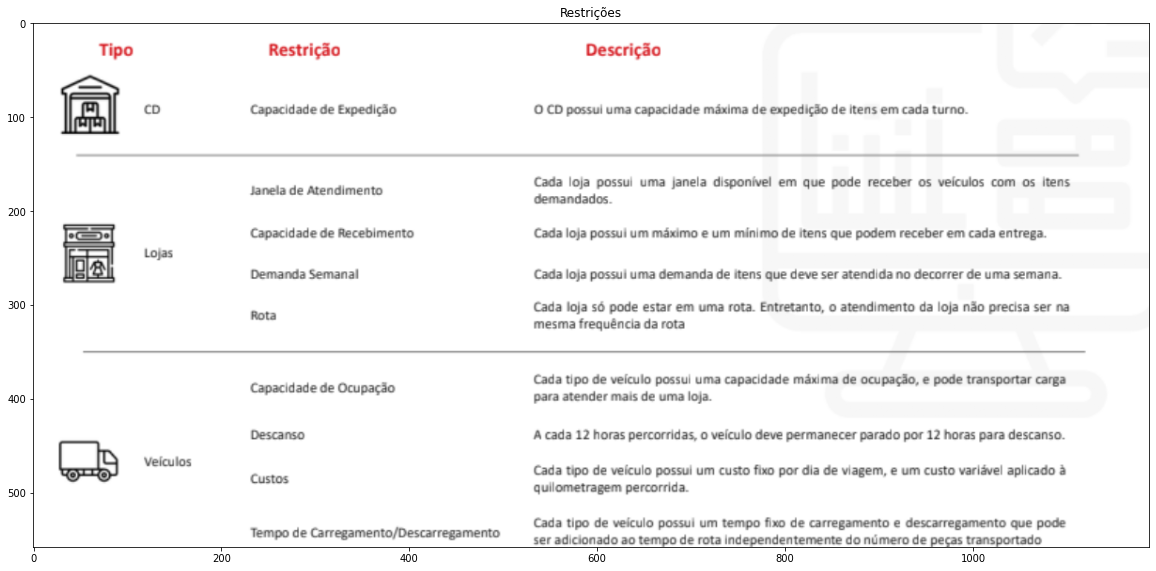

In [69]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.title("Restrições")
plt.xlabel("")
plt.ylabel("")
 
image = mpimg.imread("Imagens/restrictions.PNG")
plt.imshow(image)
plt.show()

# Pré-processamento dos dados

### Unindo os dataframes do CD (Centro de Distribuição) e das lojas

In [70]:
df_lojas.head()

ID Loja  Município  UF   Latitude  Longitude SEG  TER  QUA QUI  SEX  SAB  \
0      1.0    BARUERI  SP -23.504299 -46.834361   x    x  NaN   x    x  NaN   
1      2.0  SAO PAULO  SP -23.529674 -46.676835   x    x  NaN   x  NaN  NaN   
2      3.0  SAO PAULO  SP -23.626342 -46.656541   x    x    x   x    x  NaN   
3      4.0    BARUERI  SP -23.496201 -46.812799   x  NaN    x   x  NaN  NaN   
4      5.0  SAO PAULO  SP -23.541271 -46.575577   x    x    x   x  NaN  NaN   

  Hora Recebimento Inicial Hora Finalização Recebimento  \
0                 09:00:00                     17:00:00   
1                 09:30:00                     17:00:00   
2                 09:00:00                     16:00:00   
3                 11:00:00                     13:00:00   
4                 08:30:00                     11:30:00   

   Min. Peças p/ Entrega  Máx. Peças p/ Entrega  
0                  471.0                 3138.0  
1                  519.0                 3455.0  
2                  416.0                 2773.0  
3                  290.0                 1931.0  
4                  301.0                 2006.0

In [71]:
df_CD

Cidade  UF   Latitude  Longitude
0  Arujá  SP -23.395082  -46.35536

In [72]:
cd_row = pd.DataFrame({'ID Loja': 0,
                        'Município':df_CD['Cidade'][0].upper(), 'UF':df_CD['UF'], 
                       'Latitude':df_CD['Latitude'][0], 'Longitude':df_CD['Longitude'],
                       'SEG': 'x','TER': 'x','QUA': 'x','QUI': 'x','SEX': 'x',
                       'SAB': 'x', 'Hora Recebimento Inicial': datetime.time(0, 0),
                       'Hora Finalização Recebimento': datetime.time(23, 59),
                       'Min. Peças p/ Entrega': 0,
                       'Máx. Peças p/ Entrega': 0,
                       })

In [73]:
df_lojas = pd.concat([cd_row,df_lojas.loc[:]]).reset_index(drop = True)

In [74]:
df_lojas.head(5)

ID Loja  Município  UF   Latitude  Longitude SEG  TER  QUA QUI  SEX  SAB  \
0      0.0      ARUJÁ  SP -23.395082 -46.355360   x    x    x   x    x    x   
1      1.0    BARUERI  SP -23.504299 -46.834361   x    x  NaN   x    x  NaN   
2      2.0  SAO PAULO  SP -23.529674 -46.676835   x    x  NaN   x  NaN  NaN   
3      3.0  SAO PAULO  SP -23.626342 -46.656541   x    x    x   x    x  NaN   
4      4.0    BARUERI  SP -23.496201 -46.812799   x  NaN    x   x  NaN  NaN   

  Hora Recebimento Inicial Hora Finalização Recebimento  \
0                 00:00:00                     23:59:00   
1                 09:00:00                     17:00:00   
2                 09:30:00                     17:00:00   
3                 09:00:00                     16:00:00   
4                 11:00:00                     13:00:00   

   Min. Peças p/ Entrega  Máx. Peças p/ Entrega  
0                    0.0                    0.0  
1                  471.0                 3138.0  
2                  519.0                 3455.0  
3                  416.0                 2773.0  
4                  290.0                 1931.0

### Obtendo a matriz de distâncias entre as coordenadas

In [75]:
def calculate_distance(coords_1: np.float64, coords_2: np.float64) -> float:
  return float(geopy.distance.geodesic(coords_1, coords_2).m)

In [76]:
def generate_distance_matrix(df: pd.core.frame.DataFrame) -> np.ndarray:
  distance_matrix = np.zeros((len(df), len(df)))
  for i in range(len(df)):
    for j in range(len(df)):
      coords_1 = (df['Latitude'].iloc[i], df['Longitude'].iloc[i])
      coords_2 = (df['Latitude'].iloc[j], df['Longitude'].iloc[j])
      distance_matrix[i][j] = calculate_distance(coords_1, coords_2)
  return distance_matrix

In [77]:
dmatrix = generate_distance_matrix(df_lojas)

### Limpando o dataframe das lojas para deixá-lo com apenas as informações que serão usadas adiante

In [78]:
df_lojas.drop(['Latitude', 'Longitude'], axis = 1, inplace = True)

### Trocando 'x' por seu equivalente booleano na escala de atendimentos das lojas

In [79]:
# Para df_lojas, onde tem X ou x, singnifica que a Loja funciona. Logo, será substituído por 1. Em contrapartida, NaN será 0, pois a loja não funciona.
df_lojas_turnos = ['SEG', 'TER', 'QUA', 'QUI', 'SEX', 'SAB']

df_lojas[df_lojas_turnos] = df_lojas[df_lojas_turnos].replace('X', 1)
df_lojas[df_lojas_turnos] = df_lojas[df_lojas_turnos].replace('x', 1)

df_lojas[df_lojas_turnos] = df_lojas[df_lojas_turnos].replace(np.nan, 0)

## Modelagem do Problema

## Visualização dos dataframes disponíveis

### Turnos

In [80]:
df_turnos

Turno  Capacidade Máxima de Expedição
0    TT1                         53604.0
1    TT2                         56820.0
2    TT3                         40200.0
3    TT4                         43233.0
4    TT5                         49306.0
5    TT6                         42067.0
6    TT7                         48385.0
7    TT8                         48360.0
8    TT9                         42216.0
9   TT10                         42855.0
10  TT11                         41895.0
11  TT12                         41260.0
12  TT13                         47621.0
13  TT14                         51287.0
14  TT15                         53837.0
15  TT16                         48883.0
16  TT17                         44482.0
17  TT18                         51860.0

### Lojas

In [81]:
df_lojas.head(3)

ID Loja  Município  UF  SEG  TER  QUA  QUI  SEX  SAB  \
0      0.0      ARUJÁ  SP  1.0  1.0  1.0  1.0  1.0  1.0   
1      1.0    BARUERI  SP  1.0  1.0  0.0  1.0  1.0  0.0   
2      2.0  SAO PAULO  SP  1.0  1.0  0.0  1.0  0.0  0.0   

  Hora Recebimento Inicial Hora Finalização Recebimento  \
0                 00:00:00                     23:59:00   
1                 09:00:00                     17:00:00   
2                 09:30:00                     17:00:00   

   Min. Peças p/ Entrega  Máx. Peças p/ Entrega  
0                    0.0                    0.0  
1                  471.0                 3138.0  
2                  519.0                 3455.0

Tranformando as horas em **float** e transformando os '0's das horas de finalização em '24's, para criar uma escala de tempo adequada.

In [82]:
df_lojas['Hora Recebimento Inicial'] = df_lojas['Hora Recebimento Inicial'].apply(lambda x: x.hour + x.minute/60)
df_lojas['Hora Finalização Recebimento'] = df_lojas['Hora Finalização Recebimento'].apply(lambda x: x.hour + x.minute/60)
df_lojas['Hora Finalização Recebimento'] = df_lojas['Hora Finalização Recebimento'].apply(lambda x: float(24) if x == 0 else x)

In [83]:
df_lojas.head(3)

ID Loja  Município  UF  SEG  TER  QUA  QUI  SEX  SAB  \
0      0.0      ARUJÁ  SP  1.0  1.0  1.0  1.0  1.0  1.0   
1      1.0    BARUERI  SP  1.0  1.0  0.0  1.0  1.0  0.0   
2      2.0  SAO PAULO  SP  1.0  1.0  0.0  1.0  0.0  0.0   

   Hora Recebimento Inicial  Hora Finalização Recebimento  \
0                       0.0                     23.983333   
1                       9.0                     17.000000   
2                       9.5                     17.000000   

   Min. Peças p/ Entrega  Máx. Peças p/ Entrega  
0                    0.0                    0.0  
1                  471.0                 3138.0  
2                  519.0                 3455.0

### Lojas disponíveis por dia da semana:

In [84]:
dict_lojas_SEG = dict(zip(df_lojas['ID Loja'], df_lojas['SEG']))

dict_lojas_TER = dict(zip(df_lojas['ID Loja'], df_lojas['TER']))

dict_lojas_QUA = dict(zip(df_lojas['ID Loja'], df_lojas['QUA']))

dict_lojas_QUI = dict(zip(df_lojas['ID Loja'], df_lojas['QUI']))

dict_lojas_SEX = dict(zip(df_lojas['ID Loja'], df_lojas['SEX']))

dict_lojas_SAB = dict(zip(df_lojas['ID Loja'], df_lojas['SAB']))

### Lista dos a_{i}, início da time window do cliente i.

In [85]:
a = list(df_lojas['Hora Recebimento Inicial'])
print(a)

[0.0, 9.0, 9.5, 9.0, 11.0, 8.5, 13.0, 6.5, 8.0, 9.0, 9.0, 6.0, 6.0, 8.0, 11.0, 6.0, 6.0, 10.0, 6.0, 13.0, 19.0, 8.0, 9.0, 8.0, 10.0, 9.0, 6.0, 10.0, 10.0, 10.0, 11.0, 6.0, 6.0, 9.0, 10.0, 0.0, 9.0, 9.0, 8.0, 6.0, 0.0, 6.0, 6.0, 6.0, 7.0, 8.0, 9.0, 9.0, 10.0, 9.0, 11.0, 0.0, 6.5, 8.0, 9.0, 0.0, 9.0, 10.0, 8.0, 9.0, 9.5, 9.0, 11.0, 8.5, 13.0, 7.5, 8.0, 9.0, 10.0, 7.0, 11.0, 8.0, 11.0, 10.0, 19.0, 10.0, 11.0, 11.0, 9.0, 9.0, 9.0, 9.0, 10.0, 11.0, 10.0, 13.0, 7.0, 14.0, 10.0, 9.0, 8.0, 10.0, 9.0, 7.0, 7.5, 7.5, 9.0, 10.0, 10.0, 11.0, 10.0, 6.0, 9.0, 8.0, 9.0, 9.0, 8.0, 10.0, 10.0, 9.0, 11.0, 9.0, 9.0, 11.0, 9.0, 11.0, 10.0, 7.5, 7.5, 0.0, 8.0, 8.0, 10.0, 9.0, 7.0, 8.0, 10.0, 6.5, 7.5, 7.0, 16.0, 12.0, 13.0, 7.0]


### Lista dos b_{i}, fim da time window do cliente i.

In [86]:
b = list(df_lojas['Hora Finalização Recebimento'])
print(b)

[23.983333333333334, 17.0, 17.0, 16.0, 13.0, 11.5, 15.0, 9.5, 13.0, 11.0, 12.0, 9.0, 12.0, 12.0, 15.0, 10.0, 10.0, 14.0, 9.5, 23.0, 23.0, 12.0, 12.0, 18.0, 15.0, 14.0, 10.0, 16.0, 14.0, 14.0, 17.0, 10.0, 10.0, 13.0, 14.0, 6.0, 14.0, 14.0, 13.0, 11.0, 9.0, 12.0, 10.0, 10.0, 11.0, 12.0, 13.0, 13.0, 14.0, 15.0, 15.0, 8.0, 11.5, 18.0, 17.0, 6.0, 13.0, 13.0, 10.0, 17.0, 17.0, 16.0, 13.0, 11.5, 15.0, 7.5, 13.0, 11.0, 12.0, 8.0, 12.0, 12.0, 15.0, 14.0, 20.0, 13.0, 13.0, 13.0, 14.0, 10.5, 9.0, 15.0, 12.0, 17.0, 11.0, 16.0, 9.0, 16.0, 14.0, 14.0, 9.0, 14.0, 16.0, 9.5, 10.0, 9.75, 11.0, 12.0, 14.0, 13.0, 12.0, 10.5, 18.0, 11.0, 13.0, 9.0, 24.0, 14.0, 12.0, 17.0, 15.0, 17.0, 12.5, 17.0, 14.0, 17.0, 16.0, 10.5, 10.5, 8.0, 10.5, 10.0, 17.0, 11.0, 10.0, 10.0, 13.0, 9.0, 11.0, 12.0, 21.0, 18.0, 24.0, 11.0]


### Demanda

In [87]:
df_demanda.head(3)

Loja   Peças
0   1.0  3138.0
1   2.0  3455.0
2   3.0  2773.0

In [88]:
cd_demanda = pd.DataFrame({'Loja': [0], 'Peças': [0]})

df_demanda = pd.concat([cd_demanda,df_demanda.loc[:]]).reset_index(drop = True)

In [89]:
demanda = dict(zip(df_demanda['Loja'], df_demanda['Peças'])) # Conversão em dict para facilitar a adição de restrições

#### Criação da lista com as demandas de cada cliente

In [90]:
# O artigo chama essa lista de q
# O cliente 0 é o CD, por conveniência

q = list(demanda.values())
print(q)

[0.0, 3138.0, 3455.0, 2773.0, 1931.0, 2006.0, 2485.0, 2047.0, 1705.0, 2663.0, 2035.0, 2398.0, 1858.0, 2640.0, 2360.0, 2775.0, 2415.0, 1948.0, 3681.0, 2009.0, 1657.0, 2358.0, 2617.0, 2623.0, 2105.0, 3033.0, 2789.0, 1937.0, 2767.0, 2148.0, 2532.0, 1479.0, 2438.0, 2827.0, 2295.0, 2098.0, 1990.0, 2374.0, 2411.0, 2882.0, 2067.0, 1689.0, 2969.0, 1432.0, 2338.0, 2027.0, 2466.0, 2242.0, 1975.0, 2190.0, 2105.0, 1979.0, 2529.0, 1747.0, 2734.0, 2473.0, 1975.0, 2250.0, 1545.0, 2329.0, 4041.0, 1618.0, 2762.0, 1215.0, 5127.0, 3672.0, 4200.0, 2531.0, 8638.0, 3000.0, 6480.0, 7821.0, 2895.0, 3635.0, 9196.0, 1350.0, 7510.0, 10553.0, 3428.0, 3687.0, 2089.0, 2235.0, 3817.0, 1355.0, 2906.0, 6805.0, 4885.0, 2876.0, 5055.0, 3343.0, 8865.0, 2046.0, 2038.0, 4966.0, 7983.0, 4997.0, 1898.0, 3257.0, 3574.0, 2042.0, 1714.0, 3850.0, 1517.0, 3208.0, 1160.0, 4134.0, 5123.0, 2699.0, 2388.0, 1814.0, 2502.0, 2667.0, 7770.0, 3344.0, 4491.0, 3504.0, 4158.0, 1012.0, 3901.0, 4370.0, 2204.0, 3371.0, 2122.0, 9103.0, 5227.0, 1

### Veículos

In [91]:
df_veiculos.head(3)

Veículo  Capacidade Máxima (peças)  Custo por km  \
0     TOCO                     5000.0           1.6   
1  CARRETA                    10000.0           2.4   

   Custo Fixo por dia de viagem Velocidade  Tempo de carregamento (horas)  \
0                         100.0     50km/h                            0.5   
1                         150.0     50km/h                            1.0   

   Tempo de descarregamento (horas)  
0                               0.5  
1                               1.0

#### Criação de dicionários para acesso mais fácil

In [92]:
custo_km = {'TOCO': 1.6, 'CARRETA': 2.4}
capacidade_max = {'TOCO': 5000, 'CARRETA': 10000}
custos_fixos = {'TOCO': 100, 'CARRETA': 150}
velocidades = {'TOCO': 50000, 'CARRETA': 50000} # em metros/hora
carregamento = {'TOCO': 0.5, 'CARRETA': 1}
descarregamento = {'TOCO': 0.5, 'CARRETA': 1}

### Variáveis

### Matriz de distâncias

In [93]:
dmatrix

array([[    0.        , 50416.71144727, 36069.26222829, ...,
        40689.71826804, 49989.09257485, 63444.40928971],
       [50416.71144727,     0.        , 16331.4885079 , ...,
        17501.46741049, 16363.58297092, 68899.14545323],
       [36069.26222829, 16331.4885079 ,     0.        , ...,
         7059.06668353, 15203.05471629, 56978.80572027],
       ...,
       [40689.71826804, 17501.46741049,  7059.06668353, ...,
            0.        ,  9301.76087462, 52138.75594522],
       [49989.09257485, 16363.58297092, 15203.05471629, ...,
         9301.76087462,     0.        , 53482.97734947],
       [63444.40928971, 68899.14545323, 56978.80572027, ...,
        52138.75594522, 53482.97734947,     0.        ]])

### Tempo Mínimo para percorrer a aresta (i,j), de i a j

In [94]:
# O artigo chama essa matrix de d (dij)

d = dmatrix/velocidades['TOCO'] # É a mesma coisa que dmatrix/velocidades['CARRETA'], pois possuem velocidades iguais.

d # Tempos em horas.

array([[0.        , 1.00833423, 0.72138524, ..., 0.81379437, 0.99978185,
        1.26888819],
       [1.00833423, 0.        , 0.32662977, ..., 0.35002935, 0.32727166,
        1.37798291],
       [0.72138524, 0.32662977, 0.        , ..., 0.14118133, 0.30406109,
        1.13957611],
       ...,
       [0.81379437, 0.35002935, 0.14118133, ..., 0.        , 0.18603522,
        1.04277512],
       [0.99978185, 0.32727166, 0.30406109, ..., 0.18603522, 0.        ,
        1.06965955],
       [1.26888819, 1.37798291, 1.13957611, ..., 1.04277512, 1.06965955,
        0.        ]])

## Definindo as variáveis necessárias

In [95]:
# Numerando cada um dos nós do grafo.
pontos = list(range(0, 134)) # len(pontos) = 134, vai de 0 (CD) a 133.

# Número de clientes
n = len(pontos) - 1 # n = 133 clientes.

# Nomes dos veículos.
veiculos = ['TOCO', 'CARRETA'] 

# Definindo o conjunto K com n veículos 'TOCO' e n veículos 'CARRETA'.
lista_veiculos = list(range(0, 2*n)) # Teremos 266 veículos.
K = [k for k in lista_veiculos]

# Definindo o conjunto Q_til com as capacidades dos veículos de K.
Q_til = list()
for i in range(0, n):
  Q_til.append(capacidade_max['TOCO'])
for i in range(n, 2*n):
  Q_til.append(capacidade_max['CARRETA'])

# Definindo os custos por km por veículo.
c = list()
for i in range(0, n):
  c.append(custo_km['TOCO'])
for i in range(n, 2*n):
  c.append(custo_km['CARRETA'])

# Definindo o conjunto F com os custos fixos dos veículos de K.
F = list()
for i in range(0, n):
  F.append(custos_fixos['TOCO'])
for i in range(n, 2*n):
  F.append(custos_fixos['CARRETA'])

# Definindo o conjunto v com as velocidades dos veículos de K.
v = list()
for i in range(0, n):
  v.append(velocidades['TOCO'])
for i in range(n, 2*n):
  v.append(velocidades['CARRETA'])

# Definindo Ftil, o custo fixo em termos de tempo.
Ftil = list()
for i in range(0, 2*n):
  Ftil.append(F[i] / (c[i] * v[i]))

# Definindo o conjunto sk com os tempos de serviço de cada veículo. 
# (aqui associamos aos veículos, não aos clientes, diferente do artigo).
s = list()
for i in range(0, n):
  s.append(carregamento['TOCO'] + descarregamento['TOCO'])
for i in range(n, 2*n):
  s.append(carregamento['CARRETA'] + descarregamento['CARRETA'])

# Caminhos possíveis entre quaisquer dois pontos do grafo.
Caminhos = [(i, j) for i in pontos for j in pontos]

### Solução trivial

A solução trivial é composta de cada caminhão fazendo viagem de ida e volta para uma única loja. Note que todas as lojas podem ser atendidas uma única vez (embora essa solução possa não ser ótima), pois todas as demandas são menores que a capacidade de uma carreta.

# Conjuntos de rotas possíveis, indo de i a j, pelo veículo k.
# Será útil para definir o número de variáveis binárias que definem se uma rota é ou não percorrida.
Rotas = [(i, j, k) for i in pontos for j in pontos for k in K]

In [96]:
# Variáveis binárias xijk que definem se uma rota é (xijk = 1) ou não (xijk = 0) percorrida.
i_pontos = pontos
j_pontos = pontos
k_veiculos = K
x = LpVariable.dicts("Rotas", (i_pontos, j_pontos, k_veiculos), cat=LpBinary)

In [97]:
# Variáveis binárias yik que definem se o cliente i é servido (yik = 1) ou não (yik = 0) pelo veículo k.
i_pontos = pontos
k_veiculos = K
y = LpVariable.dicts("Clientes", (i_pontos, k_veiculos), cat=LpBinary)

In [98]:
# Variáveis binárias zk que definem se o veículo k é usado (zk = 1) ou não (zk = 0).
k_veiculos = K
z = LpVariable.dicts("Veiculos", (k_veiculos), cat=LpBinary)

In [99]:
# Variáveis reais tik que indicam o mínimo instante de tempo em que o veículo k
# pode possivelmente chegar no nó i.
i_pontos = pontos
k_veiculos = K
t = LpVariable.dicts("Tempo_Minimo_Chegada", (k_veiculos, i_pontos), cat=LpContinuous)

In [100]:
# Variáveis reais tali que indicam o mínimo instante de tempo no qual 
# o serviço no cliente i pode começar.
i_pontos = pontos
tal = LpVariable.dicts("Inicio_Janela",(i_pontos), cat=LpContinuous)

In [101]:
# Variáveis reais pik para determinar o instante de tempo em que o veículo k,
# se usado, começa sua rota.
k_veiculos = K
pi = LpVariable.dicts("Inicio_Rota", (k_veiculos), cat=LpContinuous)

In [102]:
# Constante positiva muito grande, utilizada nas heurísticas.

M = max(b) + max(s) + max(map(max, d))

print(M) # M medida em horas.

39.078803794241566


## Modelando o problema com a biblioteca pulp

### Declarando o problema e a variável de decisão

In [103]:
prob = LpProblem("Otimizacao_Renner", LpMinimize)

### Adicionando função objetivo ao problema de PL

In [104]:
# o problema será resolvido em termos do tempo mínimo

# (1)
prob += (
    # custos fixos em termos de tempo
    lpSum([Ftil[k] for k in K]) + \
    # tempo que chega da entrega
    lpSum([t[k][0]] for k in K) - \
    # tempo que sai da entrega
    lpSum([pi[k]] for k in K) - \
    # tempo necessário para carregar/descarregar
    lpSum([s[i] for i in pontos])
)

### Adicionando restrições ao problema

In [105]:
# Definição de y_ik
for k in K:
# y_ik = 1 se soma(x[i][j][k] para j em pontos[1:]) > 0, ou 0 cc
  for i in pontos[1:]:
    prob += (
      lpSum([x[i][j][k] for j in pontos[1:]]) <= y[i][k]
    )

    prob += (
        y[i][k] <= 1
    )

In [106]:
# Definição de z_k

for k in K:
  prob += (
      lpSum([x[i][j][k] for (i, j) in Caminhos]) <= z[k]
  )

  prob += (
      z[k] <= 1
  )

In [107]:
# (2)
for i in pontos[1:]: 
  prob += (
      lpSum([y[i][k] for k in K]) == 1
  )

In [108]:
# (3)
for i in pontos[1:]:
  for k in K:
    prob += (
        lpSum([x[j][i][k] for j in pontos]) == y[i][k]
    )

# (4)
for j in pontos[1:]:
  for k in K:
    prob += (
        lpSum([x[i][j][k] for j in pontos]) == y[i][k]
    )

In [109]:
# (5)
for k in K:
  prob += (
      lpSum([q[i]*y[i][k] for i in pontos]) <= Q_til[k] * z[k]
  )

In [110]:
# (7)
for k in K:
  for i in pontos:
    prob += (
        t[k][j] >= tal[i] + s[i] + d[i][j] - M*(1- x[i][j][k])
    )

# (8)
for k in K:
  for i in pontos:
    prob += (
        t[k][j] >= pi[k] + d[0][j] - M*(1-x[0][j][k])
    )

In [111]:
# (9)
for k in K:
  prob += (t[k][0] >= pi[k])

# (10)
for k in K:
  for i in pontos:
    prob += (tal[i] >= t[k][i])

# (11)
for i in pontos:
  prob += (tal[i] >= a[i])
  prob += (tal[i] <= b[i])

In [112]:
# (15)
for k in K:
  for i in pontos:
    prob += (t[k][i] >= 0)

# (16)
for i in pontos:
  prob += (tal[i] >= 0)

# (17)
for k in K:
  prob += (pi[k] >= 0)

## Resolvendo o problema de PL

In [113]:
# prob.solve()

Notamos que o tempo para resolução do problema modelado até agora é muito alto para os padrões buscados, após rodarmos a função prob.solve(). O próprio artigo-base utilizado indica que, de fato, os tempos para resolução do problema proposto, que foi modelado até agora com condições necessárias - mas não suficientes - para resolver o case, são, em média, muito elevados devido à grande ordem de complexidade do algoritmo de programação linear utilizado. Pode-se considerar ainda que o problema demorará mais para ser resolvido devido ao uso específico da linguagem Python. Nesse sentido, iremos buscar uma solução do problema através de algumas heurísticas, isto é, realizar o procedimento de resolução com uma abordagem mais "força bruta".

# Resolução via Heurísticas

# Bibliotecas

### Instalando e importando as bibliotecas necessárias

**(Coloque aqui as bibliotecas utilizadas nessa parte)**

## Heurísticas que serão utilizadas

### Heurística do vizinho mais próximo

**Passo-a-passo:**

1) Parte-se do depósito com um novo veículo até a cidade mais próxima.

2) Calcula-se a cidade mais próxima da última cidade inserida na rota e verifica-se se é possível atender sua demanada.

3) Se for possível atender a demanda dessa cidade, adiciona-se ela à rota. Do contrário, retorna-se o veículo ao depósito e volta-se ao passo 1.

### Heurística Contrutiva de Clark & Wright

**Passo-a-passo**:

1) Parte-se do pior cenário possível: o veículo sai do depósito, atende um único cliente e retorna.

2) Realiza-se um passo iterativo: une-se as rotas de cada veículo com base no conceito de economia.

3) Na medida em que se reduz a distância total percorrida, o número de veículos necessários também é reduzido.

### Implementação da função que localiza os n vizinhos mais próximos

In [114]:
dmatrix

array([[    0.        , 50416.71144727, 36069.26222829, ...,
        40689.71826804, 49989.09257485, 63444.40928971],
       [50416.71144727,     0.        , 16331.4885079 , ...,
        17501.46741049, 16363.58297092, 68899.14545323],
       [36069.26222829, 16331.4885079 ,     0.        , ...,
         7059.06668353, 15203.05471629, 56978.80572027],
       ...,
       [40689.71826804, 17501.46741049,  7059.06668353, ...,
            0.        ,  9301.76087462, 52138.75594522],
       [49989.09257485, 16363.58297092, 15203.05471629, ...,
         9301.76087462,     0.        , 53482.97734947],
       [63444.40928971, 68899.14545323, 56978.80572027, ...,
        52138.75594522, 53482.97734947,     0.        ]])

In [115]:
def n_nearest_neighbors(n: int, i: int, dmatrix: np.ndarray) -> list:
    '''Acha o índice dos n vizinhos mais próximos da loja i e a distância mínima de cada um, dada a matriz de distâncias dmatrix.'''
    n_nearest = list()
    sorted_distances = sorted(dmatrix[i])
    if n >= len(sorted_distances):
        n = len(sorted_distances) - 1
    for j in range(0, n):
        n_distance = sorted_distances[j + 1]
        n_nearest.append([list(dmatrix[i]).index(n_distance), n_distance])
    return n_nearest

In [116]:
n_nearest_neighbors(5, 1, dmatrix)

[[67, 1059.5671188552806],
 [66, 1580.717827144746],
 [4, 2378.0530387172835],
 [64, 2709.0897218656814],
 [48, 5423.633171546491]]

### Utilizando a heurística do vizinho mais próximo para cumprir as demandas e formar as rotas

#### Primeiramente, vamos facilitar o acesso às informações

In [117]:
print(demanda)

{0.0: 0.0, 1.0: 3138.0, 2.0: 3455.0, 3.0: 2773.0, 4.0: 1931.0, 5.0: 2006.0, 6.0: 2485.0, 7.0: 2047.0, 8.0: 1705.0, 9.0: 2663.0, 10.0: 2035.0, 11.0: 2398.0, 12.0: 1858.0, 13.0: 2640.0, 14.0: 2360.0, 15.0: 2775.0, 16.0: 2415.0, 17.0: 1948.0, 18.0: 3681.0, 19.0: 2009.0, 20.0: 1657.0, 21.0: 2358.0, 22.0: 2617.0, 23.0: 2623.0, 24.0: 2105.0, 25.0: 3033.0, 26.0: 2789.0, 27.0: 1937.0, 28.0: 2767.0, 29.0: 2148.0, 30.0: 2532.0, 31.0: 1479.0, 32.0: 2438.0, 33.0: 2827.0, 34.0: 2295.0, 35.0: 2098.0, 36.0: 1990.0, 37.0: 2374.0, 38.0: 2411.0, 39.0: 2882.0, 40.0: 2067.0, 41.0: 1689.0, 42.0: 2969.0, 43.0: 1432.0, 44.0: 2338.0, 45.0: 2027.0, 46.0: 2466.0, 47.0: 2242.0, 48.0: 1975.0, 49.0: 2190.0, 50.0: 2105.0, 51.0: 1979.0, 52.0: 2529.0, 53.0: 1747.0, 54.0: 2734.0, 55.0: 2473.0, 56.0: 1975.0, 57.0: 2250.0, 58.0: 1545.0, 59.0: 2329.0, 60.0: 4041.0, 61.0: 1618.0, 62.0: 2762.0, 63.0: 1215.0, 64.0: 5127.0, 65.0: 3672.0, 66.0: 4200.0, 67.0: 2531.0, 68.0: 8638.0, 69.0: 3000.0, 70.0: 6480.0, 71.0: 7821.0, 72.0

In [118]:
capacidade_max_recebimento = dict(zip(df_lojas['ID Loja'], df_lojas['Máx. Peças p/ Entrega']))
print(capacidade_max_recebimento)

{0.0: 0.0, 1.0: 3138.0, 2.0: 3455.0, 3.0: 2773.0, 4.0: 1931.0, 5.0: 2006.0, 6.0: 2485.0, 7.0: 2047.0, 8.0: 1705.0, 9.0: 2663.0, 10.0: 2035.0, 11.0: 2398.0, 12.0: 1858.0, 13.0: 2640.0, 14.0: 2360.0, 15.0: 2775.0, 16.0: 2415.0, 17.0: 1948.0, 18.0: 3681.0, 19.0: 2009.0, 20.0: 1657.0, 21.0: 2358.0, 22.0: 2617.0, 23.0: 2623.0, 24.0: 2105.0, 25.0: 3033.0, 26.0: 2789.0, 27.0: 1937.0, 28.0: 2767.0, 29.0: 2148.0, 30.0: 2532.0, 31.0: 1479.0, 32.0: 2438.0, 33.0: 2827.0, 34.0: 2295.0, 35.0: 2098.0, 36.0: 1990.0, 37.0: 2374.0, 38.0: 2411.0, 39.0: 2882.0, 40.0: 2067.0, 41.0: 1689.0, 42.0: 2969.0, 43.0: 1432.0, 44.0: 2338.0, 45.0: 2027.0, 46.0: 2466.0, 47.0: 2242.0, 48.0: 1975.0, 49.0: 2190.0, 50.0: 2105.0, 51.0: 1979.0, 52.0: 2529.0, 53.0: 1747.0, 54.0: 2734.0, 55.0: 2473.0, 56.0: 1975.0, 57.0: 2250.0, 58.0: 1545.0, 59.0: 2329.0, 60.0: 4041.0, 61.0: 1618.0, 62.0: 2762.0, 63.0: 1215.0, 64.0: 5127.0, 65.0: 3672.0, 66.0: 4200.0, 67.0: 2531.0, 68.0: 8638.0, 69.0: 3000.0, 70.0: 6480.0, 71.0: 7821.0, 72.0

In [119]:
demanda == capacidade_max_recebimento

True

- Vemos primeiramente que a capacidade máxima de recebimento das lojas é exatamente igual à demanda de cada uma delas.

In [120]:
hora_recebimento_inicial = dict(zip(df_lojas['ID Loja'], df_lojas['Hora Recebimento Inicial']))
print(hora_recebimento_inicial)

{0.0: 0.0, 1.0: 9.0, 2.0: 9.5, 3.0: 9.0, 4.0: 11.0, 5.0: 8.5, 6.0: 13.0, 7.0: 6.5, 8.0: 8.0, 9.0: 9.0, 10.0: 9.0, 11.0: 6.0, 12.0: 6.0, 13.0: 8.0, 14.0: 11.0, 15.0: 6.0, 16.0: 6.0, 17.0: 10.0, 18.0: 6.0, 19.0: 13.0, 20.0: 19.0, 21.0: 8.0, 22.0: 9.0, 23.0: 8.0, 24.0: 10.0, 25.0: 9.0, 26.0: 6.0, 27.0: 10.0, 28.0: 10.0, 29.0: 10.0, 30.0: 11.0, 31.0: 6.0, 32.0: 6.0, 33.0: 9.0, 34.0: 10.0, 35.0: 0.0, 36.0: 9.0, 37.0: 9.0, 38.0: 8.0, 39.0: 6.0, 40.0: 0.0, 41.0: 6.0, 42.0: 6.0, 43.0: 6.0, 44.0: 7.0, 45.0: 8.0, 46.0: 9.0, 47.0: 9.0, 48.0: 10.0, 49.0: 9.0, 50.0: 11.0, 51.0: 0.0, 52.0: 6.5, 53.0: 8.0, 54.0: 9.0, 55.0: 0.0, 56.0: 9.0, 57.0: 10.0, 58.0: 8.0, 59.0: 9.0, 60.0: 9.5, 61.0: 9.0, 62.0: 11.0, 63.0: 8.5, 64.0: 13.0, 65.0: 7.5, 66.0: 8.0, 67.0: 9.0, 68.0: 10.0, 69.0: 7.0, 70.0: 11.0, 71.0: 8.0, 72.0: 11.0, 73.0: 10.0, 74.0: 19.0, 75.0: 10.0, 76.0: 11.0, 77.0: 11.0, 78.0: 9.0, 79.0: 9.0, 80.0: 9.0, 81.0: 9.0, 82.0: 10.0, 83.0: 11.0, 84.0: 10.0, 85.0: 13.0, 86.0: 7.0, 87.0: 14.0, 88.0: 10.0,

In [121]:
hora_finalizacao_recebimento = dict(zip(df_lojas['ID Loja'], df_lojas['Hora Finalização Recebimento']))
hora_finalizacao_recebimento[0] = float(24)
print(hora_finalizacao_recebimento)

{0.0: 24.0, 1.0: 17.0, 2.0: 17.0, 3.0: 16.0, 4.0: 13.0, 5.0: 11.5, 6.0: 15.0, 7.0: 9.5, 8.0: 13.0, 9.0: 11.0, 10.0: 12.0, 11.0: 9.0, 12.0: 12.0, 13.0: 12.0, 14.0: 15.0, 15.0: 10.0, 16.0: 10.0, 17.0: 14.0, 18.0: 9.5, 19.0: 23.0, 20.0: 23.0, 21.0: 12.0, 22.0: 12.0, 23.0: 18.0, 24.0: 15.0, 25.0: 14.0, 26.0: 10.0, 27.0: 16.0, 28.0: 14.0, 29.0: 14.0, 30.0: 17.0, 31.0: 10.0, 32.0: 10.0, 33.0: 13.0, 34.0: 14.0, 35.0: 6.0, 36.0: 14.0, 37.0: 14.0, 38.0: 13.0, 39.0: 11.0, 40.0: 9.0, 41.0: 12.0, 42.0: 10.0, 43.0: 10.0, 44.0: 11.0, 45.0: 12.0, 46.0: 13.0, 47.0: 13.0, 48.0: 14.0, 49.0: 15.0, 50.0: 15.0, 51.0: 8.0, 52.0: 11.5, 53.0: 18.0, 54.0: 17.0, 55.0: 6.0, 56.0: 13.0, 57.0: 13.0, 58.0: 10.0, 59.0: 17.0, 60.0: 17.0, 61.0: 16.0, 62.0: 13.0, 63.0: 11.5, 64.0: 15.0, 65.0: 7.5, 66.0: 13.0, 67.0: 11.0, 68.0: 12.0, 69.0: 8.0, 70.0: 12.0, 71.0: 12.0, 72.0: 15.0, 73.0: 14.0, 74.0: 20.0, 75.0: 13.0, 76.0: 13.0, 77.0: 13.0, 78.0: 14.0, 79.0: 10.5, 80.0: 9.0, 81.0: 15.0, 82.0: 12.0, 83.0: 17.0, 84.0: 11.0,

- Agora temos acesso fácil às horas de recebimento inicial e final de cada loja.

In [122]:
print('Dados dos veículos\n')
print(f'Custo por km em R$: {custo_km}')
print(f'Capacidade máxima em unidades:{capacidade_max}')
print(f'Custos fixos em R$: {custos_fixos}')
print(f'Velocidades em m/h: {velocidades}')
print(f'Tempo de carregamento em h: {carregamento}')
print(f'Tempo de descarregamento em h: {descarregamento}')

Dados dos veículos

Custo por km em R$: {'TOCO': 1.6, 'CARRETA': 2.4}
Capacidade máxima em unidades:{'TOCO': 5000, 'CARRETA': 10000}
Custos fixos em R$: {'TOCO': 100, 'CARRETA': 150}
Velocidades em m/h: {'TOCO': 50000, 'CARRETA': 50000}
Tempo de carregamento em h: {'TOCO': 0.5, 'CARRETA': 1}
Tempo de descarregamento em h: {'TOCO': 0.5, 'CARRETA': 1}


- Agora temos visualização e acesso fácil aos dados dos veículos.

#### Vamos criar o objeto vehicle (veículo) para conseguirmos acessar e modificar as informações de cada um com facilidade

In [144]:
class vehicle:
    current_load = 0
    km_cost = 0
    max_capacity = 0
    fixed_cost = 0
    velocity = 0
    charge_time = 0
    discharge_time = 0
    current_load = max_capacity
    current_cost = fixed_cost
    current_work_time = 0
    routes = {'MON': list(), 'TUE': list(), 'WED': list(), 'TRU': list(), 'FRI': list(), 'SAT': list()}
    
    def __init__(self, vehicle_index: int):
        self.vehicle_index = vehicle_index
        
    def get_vehicle_number(self):
        return vehicle_index
    
    def get_current_load(self):
        return self.current_load
    
    def get_current_cost(self):
        return self.current_cost
    
    def get_current_work_time(self):
        return self.current_work_time
    
    def get_routes(self):
        return self.routes
    
    def update_current_load(self, new_load):
        self.current_load = new_load
        
    def update_current_cost(self, new_cost):
        self.current_cost = new_cost
        
    def update_current_work_time(self, new_work_time):
        self.current_work = new_work_time
        
    def update_routes(self, new_routes):
        self.routes = new_routes
        
    def reduce_load_while_discharging(self, store_load: float):
        '''Atualiza a carga do veículo após descarregar em uma loja, passada a carga que a loja necessita.'''
        self.current_load = self.current_load - store_load  
        
    def increase_work_time(self, dmatrix, first_store_index, second_store_index):
        '''Atualiza o tempo de trabalho do veículo ao percorrer uma aresta entre duas lojas.'''
        self.current_work_time = self.current_work_time + dmatrix[first_store_index][second_store_index]/velocity + discharge_time
        
    def reset_current_work_time(self):
        ''' Reinicia o tempo de trabalho do veículo para que possa trabalhar em outro turno 12h depois.'''
        self.current_work_time = 0 # Veículo retorna ao CD e não é mais usado.
        
    def increase_cost(self, dmatrix, first_store_index, second_store_index):
        '''Atualiza o custo do veículo ao percorrer uma aresta entre duas lojas.'''
        self.current_cost = self.current_cost + dmatrix[first_store_index][second_store_index]*self.km_cost
        
    def add_store_to_route(self, day: str, store_index: int): # adicionamos aqui somente as lojas atendidas, não o CD.
        '''Adiciona o índice de uma loja às rotas do veículo.'''
        self.routes[day].append(store_index)
     
    @staticmethod
    def get_turns(day: str, beginning_hour: float, ending_hour: float) -> list:
        '''Dados os horários de começo e fim, e o dia, retorna os turnos que estão associados a esse intervalo de tempo.'''
        turns = list()
        days = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT']
        day_index = days.index(day)
        
        if(beginning_hour == 8):
            if 8 < ending_hour <= 16:
                turns.append(f'TT{3*day_index + 2}')
            elif 16 < ending_hour <= 24:
                turns.append(f'TT{3*day_index + 2}')
                turns.append(f'TT{3*day_index + 3}')
        
        elif(0 <= beginning_hour < 8):
            if 0 <= ending_hour <= 8:
                turns.append(f'TT{3*day_index + 1}')
            elif 8 < ending_hour <= 16:
                turns.append(f'TT{3*day_index + 1}')
                turns.append(f'TT{3*day_index + 2}')
            elif 16 < ending_hour <= 24:
                turns.append(f'TT{3*day_index + 1}')
                turns.append(f'TT{3*day_index + 2}')
                turns.append(f'TT{3*day_index + 3}')
        
        elif(beginning_hour == 16):
            if 16 < ending_hour <= 24:
                turns.append(f'TT{3*day_index + 3}')
        
        elif(8 < beginning_hour < 16):
            if 8 <= ending_hour <= 16:
                turns.append(f'TT{3*day_index + 2}')
            elif 16 < ending_hour <= 24:
                turns.append(f'TT{3*day_index + 2}')
                turns.append(f'TT{3*day_index + 3}')
    
        elif(16 < beginning_hour <= 24):
            turns.append(f'TT{3*day_index + 3}')
            
        return turns
    

In [145]:
class toco(vehicle):
    km_cost = 1.6
    max_capacity = 5000 
    fixed_cost = 100
    velocity = 50000
    charge_time = 0.5
    discharge_time = 0.5 
    current_load = max_capacity
    current_cost = fixed_cost
    
    def __str__(self):
        return f'Número do veículo: {self.vehicle_index}\nTipo do veículo: TOCO\nCarga atual: {self.current_load}\nCusto atual: {self.current_cost}\nTempo de trabalho atual: {self.current_work_time}\nRotas do veículo na semana: {self.routes}'
    
    def get_equivalent_carreta(self):
        '''Gera uma carreta equivalente ao toco de origem, dado o índice do veículo.'''
        new_carreta = carreta(self.vehicle_index)
        new_carreta.update_current_load(self.get_current_load())
        new_carreta.update_current_cost(self.get_current_cost())
        new_carreta.update_current_work_time(self.get_current_work_time())
        new_carreta.update_routes(self.get_routes())
        return new_carreta
        

In [146]:
class carreta(vehicle):
    km_cost = 2.4
    max_capacity = 10000
    fixed_cost = 150
    velocity = 50000
    charge_time = 1
    discharge_time = 1
    current_load = max_capacity
    current_cost = fixed_cost
    
    def __str__(self):
        return f'Número do veículo: {self.vehicle_index}\nTipo do veículo: CARRETA\nCarga atual: {self.current_load}\nCusto atual: {self.current_cost}\nTempo de trabalho atual: {self.current_work_time}\nRotas do veículo na semana: {self.routes}'
    
    def get_equivalent_toco(self):
        '''Gera um toco equivalente à carreta de origem, dado o índice do veículo.'''
        new_toco = toco(self.vehicle_index)
        new_toco.update_current_load(self.get_current_load())
        new_toco.update_current_cost(self.get_current_cost())
        new_toco.update_current_work_time(self.get_current_work_time())
        new_toco.update_routes(self.get_routes())
        return new_toco

- Da análise dos dados, não há o caso em que 'Hora de Recebimento Inicial' > 'Hora Finalização Recebimento', por isso não tratamos desse caso na função get_turns.
- Isto é, cada loja termina seu atendimento antes do início da madrugada ou começa seu atendimento após o início da madrugada.

In [147]:
df_lojas[df_lojas['Hora Recebimento Inicial'] > df_lojas['Hora Finalização Recebimento']]

Empty DataFrame
Columns: [ID Loja, Município, UF, SEG, TER, QUA, QUI, SEX, SAB, Hora Recebimento Inicial, Hora Finalização Recebimento, Min. Peças p/ Entrega, Máx. Peças p/ Entrega]
Index: []

- Na inicialização do veículo, começaremos sempre com 'CARRETA', e trocaremos por 'TOCO' se possível durante o ciclo 'for'.
- Por exemplo:

In [148]:
toco1 = toco(1)

In [149]:
print(toco1)

Número do veículo: 1
Tipo do veículo: TOCO
Carga atual: 5000
Custo atual: 100
Tempo de trabalho atual: 0
Rotas do veículo na semana: {'MON': [], 'TUE': [], 'WED': [], 'TRU': [], 'FRI': [], 'SAT': []}


Criando uma carreta equivalente ao toco anterior:

In [150]:
carreta1 = toco1.get_equivalent_carreta()
print(carreta1)

Número do veículo: 1
Tipo do veículo: CARRETA
Carga atual: 5000
Custo atual: 100
Tempo de trabalho atual: 0
Rotas do veículo na semana: {'MON': [], 'TUE': [], 'WED': [], 'TRU': [], 'FRI': [], 'SAT': []}
